### Notebook to plot mean vertical profiles of vertical motion and other variables from WRF model output for new stratiform paper.

James Ruppert  
jruppert@ou.edu  
7/11/24

In [14]:
import numpy as np
from matplotlib import ticker, rc
import matplotlib.pyplot as plt
import sys
from scipy import stats
from thermo_functions import *
from precip_class import *
from memory_usage import *
from read_functions import *
import pickle

### Main settings

In [15]:
# #### Main settings

storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
datdir2 = 'post/d02/'
main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'
figdir = "/home/jamesrup/figures/tc/ens/boxplot/"

t1_test=24 # n time steps to sample for tests
nt=t1_test

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 3
enstag = str(nmem)

In [31]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
test_str='ctl'
datdir = main+storm+'/'+memb_all[0]+'/'+test_str+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
# dp = (pres[1]-pres[0])*1e2 # Pa
nx1-=80*2
nx2-=80*2
# Setting for (vertical) HiRes output
nz=39
pres = np.arange(1000,25,-25)
dp = (pres[0]-pres[1])*1e2 # Pa

In [17]:
# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','CONVOFF','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']

ntest = len(tests)

# 0-5: pclass 0-5
# 6: pclass=1,4,5 (deep conv + strat + anvil)
# 7 = where PW ≥ 48 (Mapes et al. 2018)
# 8 = where PW < 48 (Mapes et al. 2018)
# 9 = whole domain
nmean=10
mean_str = ["Non-cloud", "Deep", "Cong", "Shallow", "Strat", "Anvil", 'MCS', 'Moist', 'Dry', 'All']
imean_sel = [1,4,5,6,7,8,9]
nmean_sel = len(imean_sel)

### Read loop

In [18]:
# Main read loops for 3D (dependent) variables

# Arrays to save variables
dims = (nmem, ntest, nmean, nt, nz)
w    = np.zeros(dims)
rho  = np.zeros(dims)
qv   = np.zeros(dims)
tmpk = np.zeros(dims)
lw = np.zeros(dims)
lwc = np.zeros(dims)
sw = np.zeros(dims)
swc = np.zeros(dims)

# Loop over ensemble members
for imemb in range(nmem):

    pickle_file = main_pickle+memb_all[imemb]+'/mean_profiles_'+str(t1_test)+'hrs.pkl'
    with open(pickle_file, 'rb') as file:
        iw_mean, irho_mean, iqv_mean, itmpk_mean, \
        ilw_mean, ilwc_mean, isw_mean, iswc_mean = pickle.load(file)
    w[imemb,:]    = iw_mean
    rho[imemb,:]  = irho_mean
    qv[imemb,:]   = iqv_mean
    tmpk[imemb,:] = itmpk_mean
    lw[imemb,:]   = ilw_mean
    lwc[imemb,:]  = ilwc_mean
    sw[imemb,:]   = isw_mean
    swc[imemb,:]  = iswc_mean

In [41]:
ik_sum = np.where(pres >= 100)

In [43]:
# Vertical integrated mass flux
g = 9.81 # m/s2
p_top = 100 # Pa, integration top
ik_sum = np.where(pres >= p_top)
vmf = np.sum(w[...,ik_sum], axis=4)*dp/g

### Plot functions

In [19]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

#### Select plot variable

In [20]:
# Plot variable
pltvar = w*rho
units = 'kg/m$^2$/s'
var_tag = 'VMF'

In [21]:
# Average profiles over time
it_max=24
pltvar_tavg = np.mean(pltvar[...,0:it_max,:], axis=3)

In [22]:
# Confidence interval using T-test and assuming 95% significance
def mean_confidence_interval(data):
    conf_set=0.95 # Confidence interval to apply throughout
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    # num = stats.t.ppf((1 + conf_set) / 2., n-1)
    h = se * stats.t.ppf((1 + conf_set) / 2., n-1)
    return m, m-h, m+h

In [27]:
# # for imean in range(nmean):
# for iimean in range(nmean_sel):

#     imean = imean_sel[iimean]

#     # create figure
#     # fig = plt.figure(figsize=(10,5))
#     fig = plt.figure(figsize=(6,5))
#     ax = fig.add_subplot(111)

#     ax.set_title(var_tag+' ('+mean_str[imean]+')')
#     ax.set_ylabel('Pressure [hPa]')

#     ax.invert_yaxis()
#     ax.set_yscale('log')

#     linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
#     linecolor=['red', 'blue', 'green', 'yellow', 'orange']

#     ctl_ensmean = np.mean(pltvar_tavg[:,0,:,:], axis=0)
#     pltvar_tavg_anom = pltvar_tavg - ctl_ensmean[np.newaxis,...]
#     for itest in range(ntest):
#         # mean, low, high = mean_confidence_interval(w_tavg[:,itest,imean,:])
#         mean, low, high = mean_confidence_interval(pltvar_tavg_anom[:,itest,imean,:])
#         plt.fill_betweenx(pres, low, high, alpha=0.2, color=linecolor[itest])
#         plt.plot(mean, pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])

#     ax.set_ylim(1000, 100)
#     ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#     ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())

#     plt.axvline(x=0,color='k',linewidth=0.5)
#     ax.set_xlabel(units)
#     # vmax=0.04
#     # plt.xlim(-1*vmax,vmax)
#     plt.legend(loc="upper right")

#     plt.show()

#### Visualize time dependency

In [24]:
# Using time-derivative
# it_max=24
pltvar_ddt = np.gradient(pltvar[...,0:it_max,:], axis=3)
pltvar_ddtmn1 = np.mean(pltvar_ddt, axis=(0,3))

In [25]:
# Using time-regression
it_max=24
time_array = np.arange(it_max)
dims=(nmem,ntest,nmean,nz)
pltvar_ddt = np.zeros(dims)
for imemb in range(nmem):
    for itest in range(ntest):
        for imean in range(nmean):
            for iz in range(nz):
                slope, intercept, r, p, se = stats.linregress(time_array, pltvar[imemb,itest,imean,0:it_max,iz])
                pltvar_ddt[imemb,itest,imean,iz] = slope
pltvar_ddtmn2 = np.mean(pltvar_ddt, axis=0)

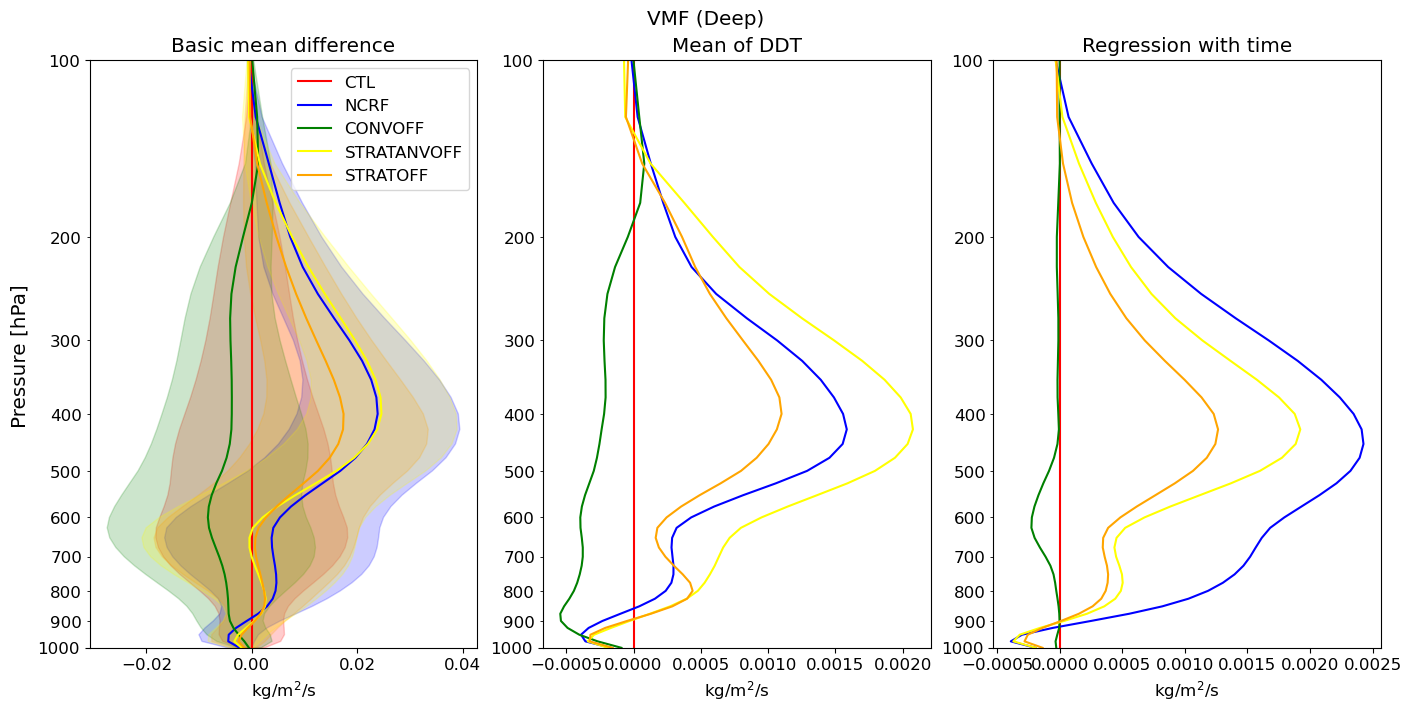

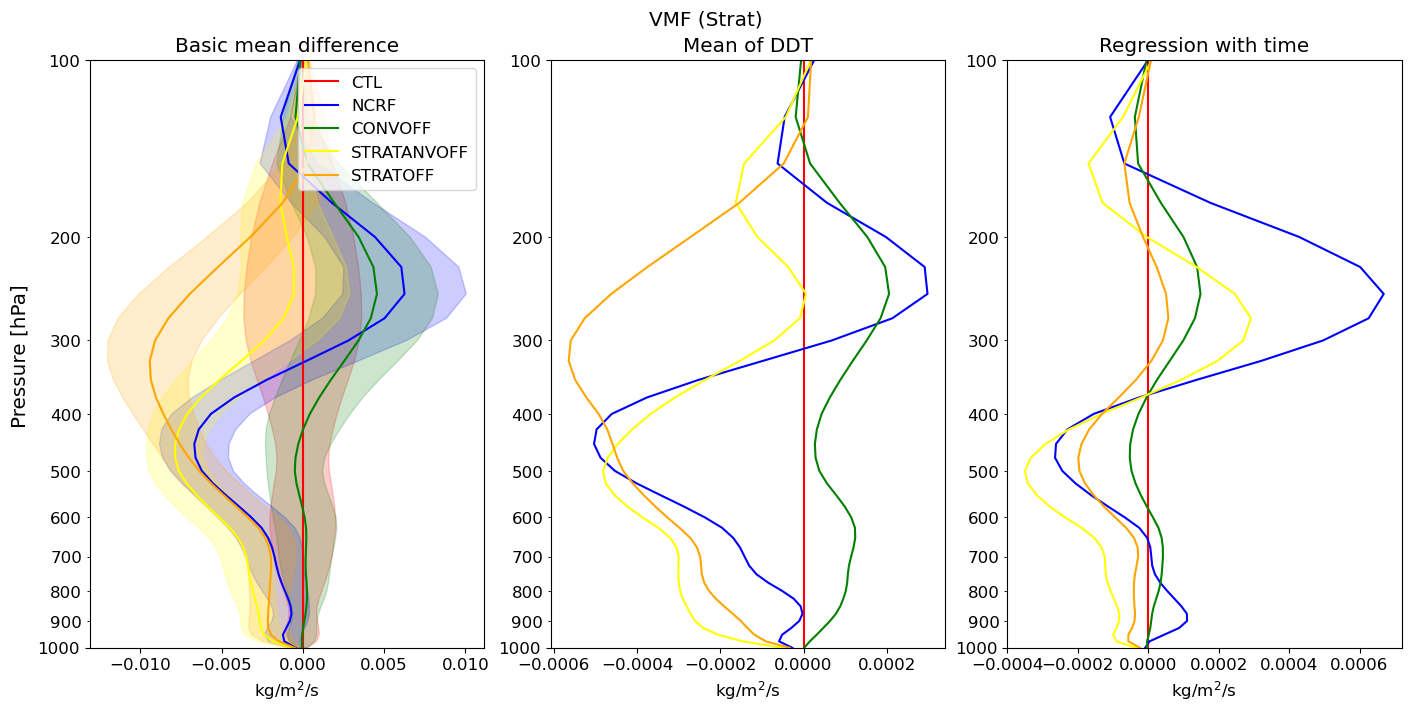

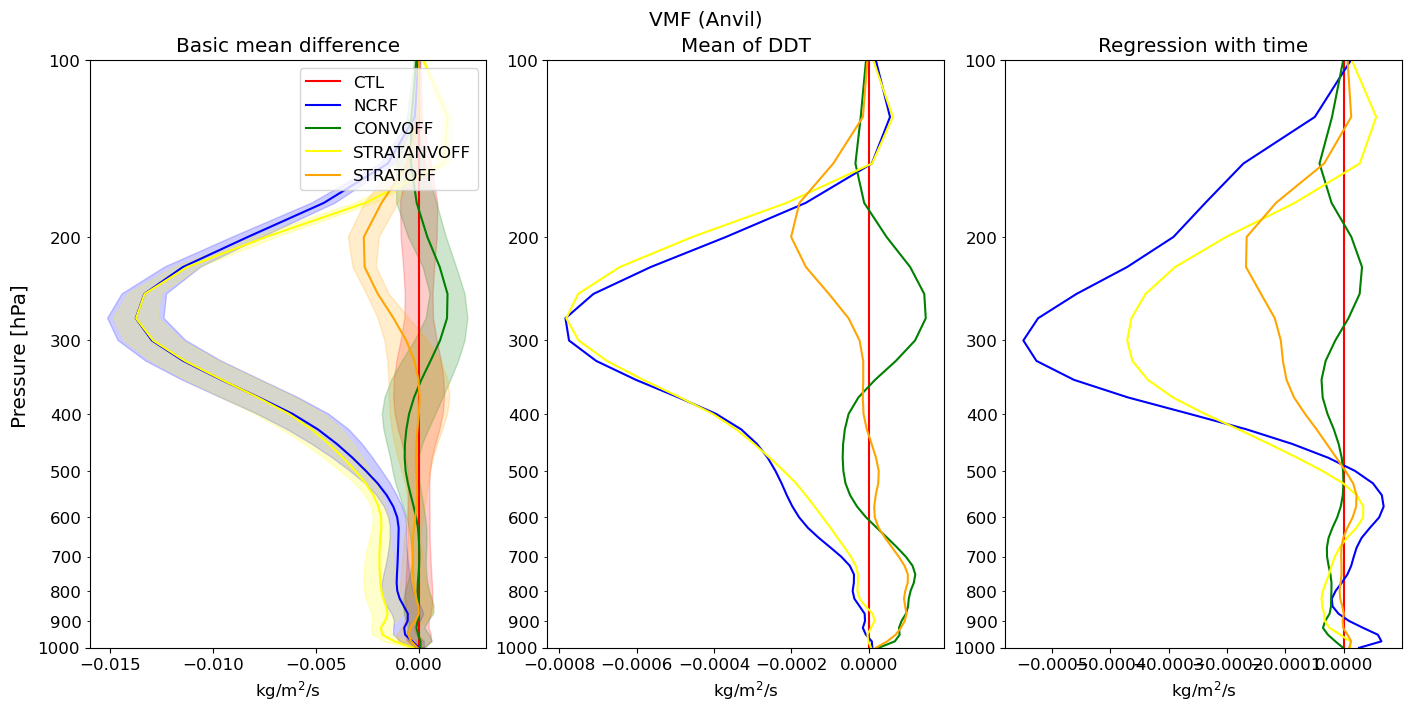

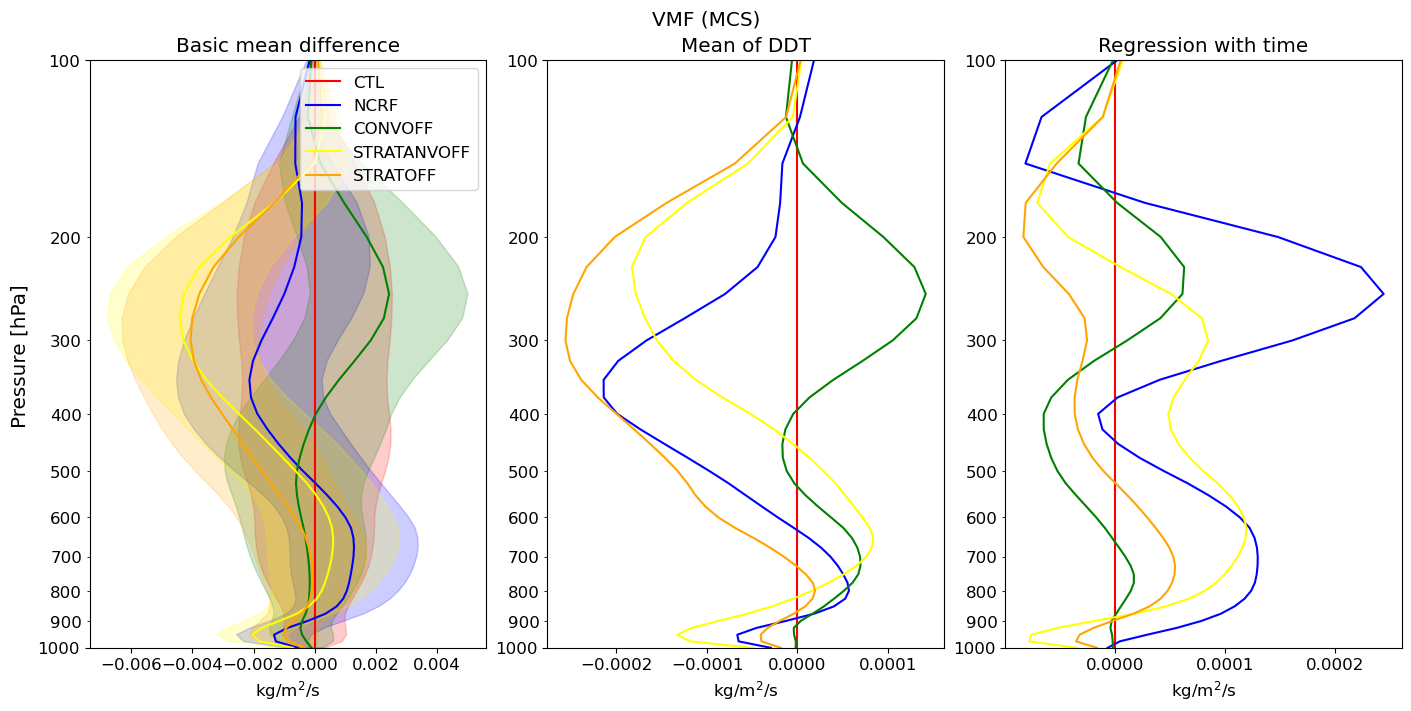

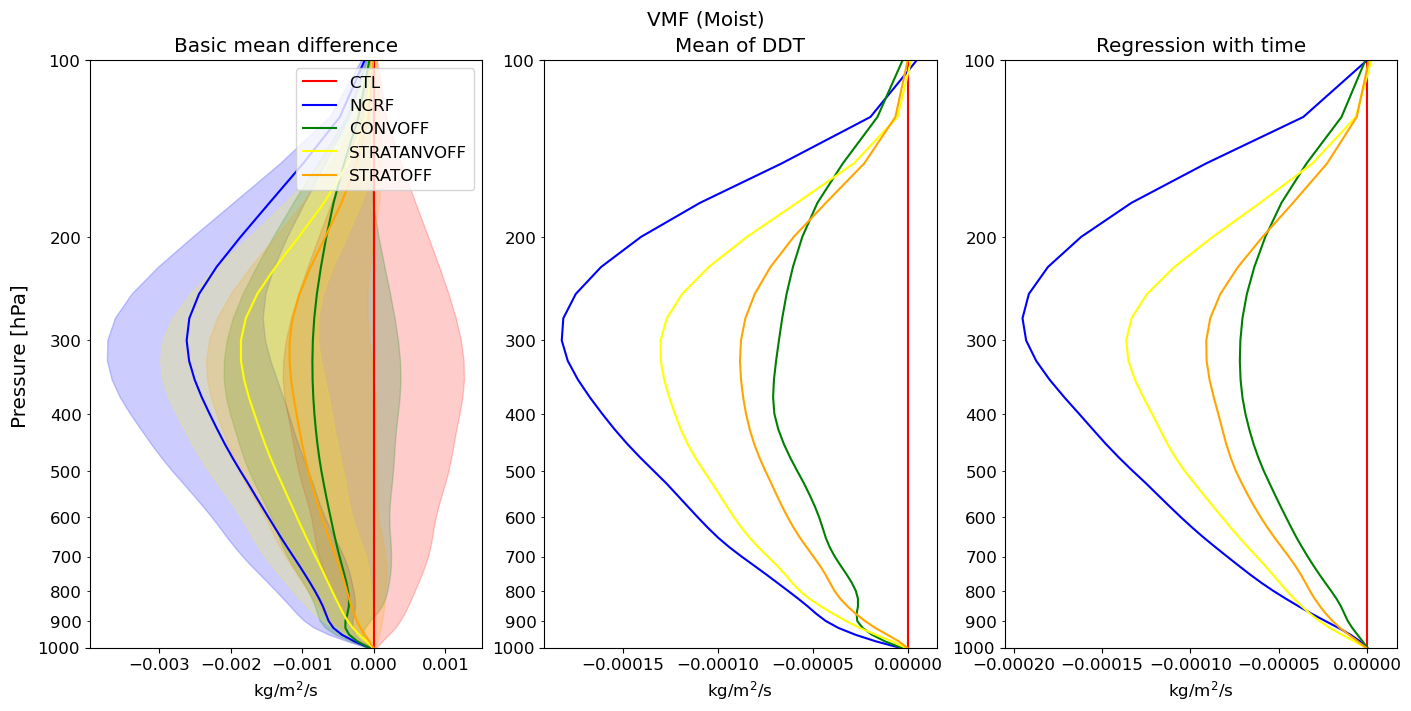

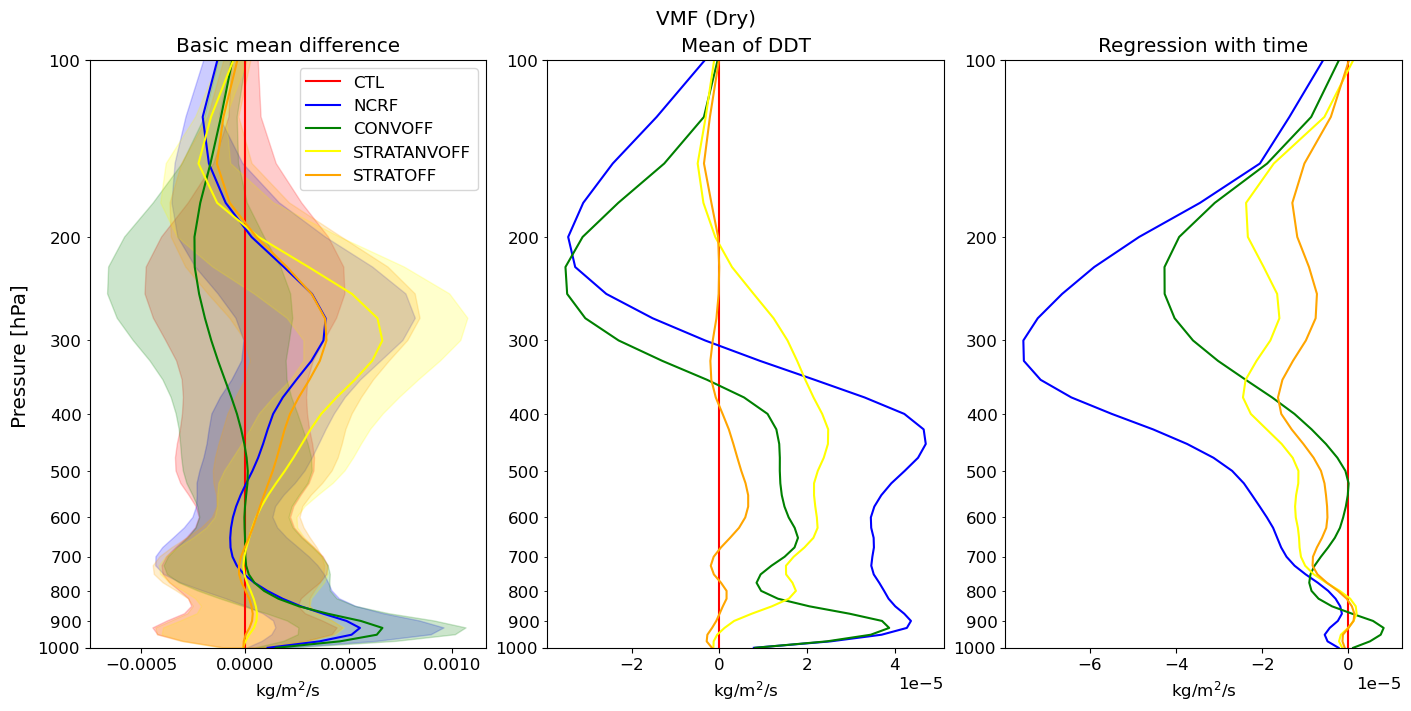

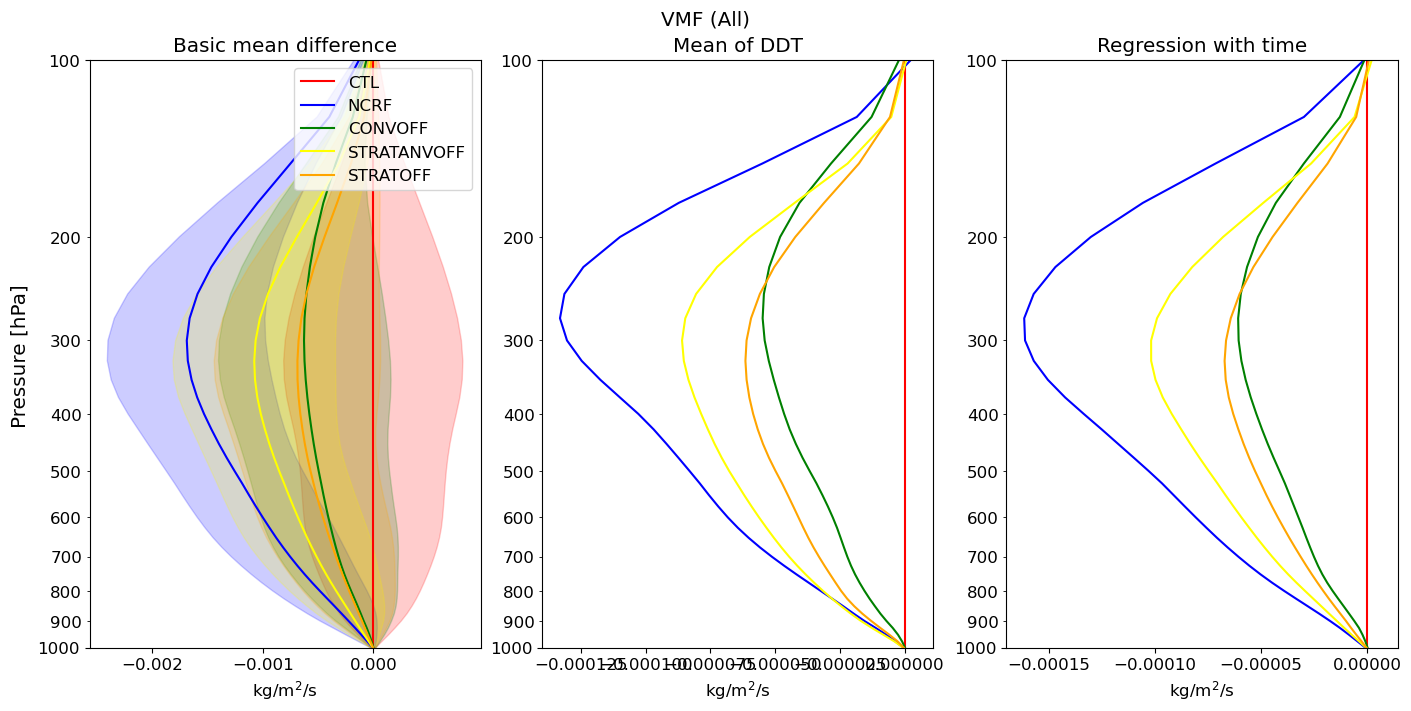

In [26]:
# for imean in range(nmean):
for iimean in range(nmean_sel):

    imean = imean_sel[iimean]

    # create figure
    fig, ax = plt.subplots(1,3, figsize=(14,7), layout="constrained",) # row, column
            # width_ratios=[5,2,5,2,5,2])
    # fig = plt.figure(figsize=(6,5))
    # ax = fig.add_subplot(111)

    fig.suptitle(var_tag+' ('+mean_str[imean]+')')
    fig.supylabel('Pressure [hPa]')

    for iax in ax:
        iax.invert_yaxis()
        iax.set_yscale('log')
        iax.set_ylim(1000, 100)
        iax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        iax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
        iax.axvline(x=0,color='k',linewidth=0.5)
        iax.set_xlabel(units)
    # vmax=0.04
    # plt.xlim(-1*vmax,vmax)

    linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
    linecolor=['red', 'blue', 'green', 'yellow', 'orange']

    ctl_ensmean = np.mean(pltvar_tavg[:,0,:,:], axis=0)
    pltvar_tavg_anom = pltvar_tavg - ctl_ensmean[np.newaxis,...]

    ctl_ddt_ensmean = pltvar_ddtmn1[0,:,:]
    w_anom1 = pltvar_ddtmn1 - ctl_ddt_ensmean[np.newaxis,...]
    ctl_ddt_ensmean = pltvar_ddtmn2[0,:,:]
    w_anom2 = pltvar_ddtmn2 - ctl_ddt_ensmean[np.newaxis,...]

    for itest in range(ntest):
        mean, low, high = mean_confidence_interval(pltvar_tavg_anom[:,itest,imean,:])
        ax[0].fill_betweenx(pres, low, high, alpha=0.2, color=linecolor[itest])
        ax[0].plot(mean, pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
        ax[1].plot(w_anom1[itest,imean], pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
        ax[2].plot(w_anom2[itest,imean], pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
        ax[0].set_title('Basic mean difference')
        ax[1].set_title('Mean of DDT')
        ax[2].set_title('Regression with time')

    ax[0].legend(loc="upper right")

    plt.show()